# Cachorro ou Gato

Um projeto para classificar imagens de cachorros e gatos, usando de Redes Neurais Convolacionais (CNN) com o Keras.

O dataset foi retirado de uma antiga competição do Kaggle, mais informações e para conseguir os arquivos zip [clique aqui](https://www.kaggle.com/c/dogs-vs-cats/overview).

In [1]:
import pandas as pd
import numpy as np
import zipfile
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

Using TensorFlow backend.


Extraindo as imagens de treino do arquivo zip.

In [2]:
# with zipfile.ZipFile('data/train.zip', 'r') as z:
#     z.extractall('data/')

Colocando os arquivos em um dataset e separando os cachorros dos gatos.

In [3]:
train_path = 'data/train'
filenames = os.listdir(train_path)
categorias = []
arquivos = []

for filename in filenames:
    arquivos.append(train_path + '/' + filename)
    categoria = filename.split('.')[0]
    if categoria == 'dog':
        categorias.append(1)
    else:
        categorias.append(0)
        
dogcat = pd.DataFrame({'arquivo': arquivos, 'categoria': categorias})

In [4]:
dogcat.head()

,arquivo,categoria
0,data/train/cat.0.jpg,0
1,data/train/cat.1.jpg,0
2,data/train/cat.10.jpg,0
3,data/train/cat.100.jpg,0
4,data/train/cat.1000.jpg,0


In [5]:
dogcat.tail()

,arquivo,categoria
24995,data/train/dog.9995.jpg,1
24996,data/train/dog.9996.jpg,1
24997,data/train/dog.9997.jpg,1
24998,data/train/dog.9998.jpg,1
24999,data/train/dog.9999.jpg,1


O dataset é dividido igualmente entre os dois.

In [6]:
dogcat['categoria'].value_counts()

1    12500
0    12500
Name: categoria, dtype: int64

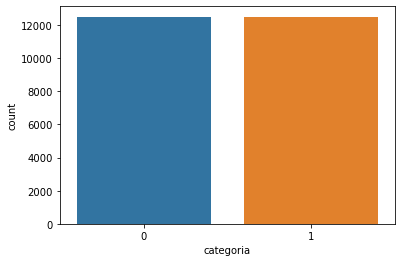

In [7]:
sns.countplot(dogcat['categoria'])

Uma amostra de imagem.

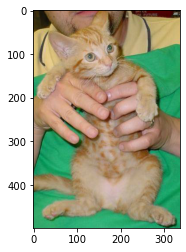

In [8]:
amostra = dogcat['arquivo'][15]
imagem = load_img(amostra)
plt.imshow(imagem)

Separando o treino e a validação

In [9]:
np.random.seed(123)

train, valid = train_test_split(dogcat, test_size=0.2, stratify=dogcat['categoria'])

In [10]:
train['categoria'].value_counts()

1    10000
0    10000
Name: categoria, dtype: int64

In [11]:
valid['categoria'].value_counts()

1    2500
0    2500
Name: categoria, dtype: int64

In [12]:
train = train.reset_index()
valid = valid.reset_index()

train['categoria'] = train['categoria'].astype(str)
valid['categoria'] = valid['categoria'].astype(str)

Utilizando o ImageDataGenerator para colocar todas as imagens na mesma dimensão e pegar imagens em diferentes formas.

In [13]:
treino_imagens = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

treino_gerador = treino_imagens.flow_from_dataframe(
    train,
    x_col='arquivo',
    y_col='categoria',
    target_size=(255, 255),
    class_mode='binary',
    batch_size=64
)

Found 20000 validated image filenames belonging to 2 classes.


In [14]:
validacao_imagens = ImageDataGenerator(rescale=1./255)

validacao_gerador = validacao_imagens.flow_from_dataframe(
    valid,
    x_col='arquivo',
    y_col='categoria',
    target_size=(255, 255),
    class_mode='binary',
    batch_size=64
)

Found 5000 validated image filenames belonging to 2 classes.


Aqui é um exemplo de como as imagens ficam.

In [15]:
exemplo = train.sample(n=1).reset_index(drop=True)
exemplo_gerador = treino_imagens.flow_from_dataframe(
    exemplo,  
    x_col='arquivo',
    y_col='categoria',
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


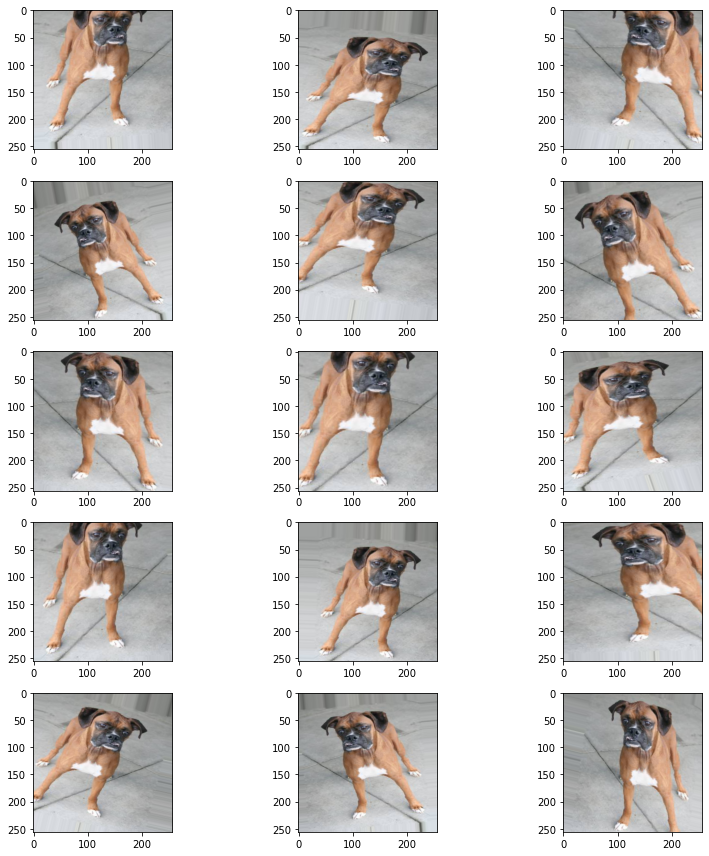

In [16]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in exemplo_gerador:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Costruindo a CNN.

Usando "early stoppind" para parar o treinamento depois de 10 épocas sem melhoras nos resultados.

In [17]:
earlystop = EarlyStopping(patience=10)
callbacks = [earlystop]

In [18]:
modelo = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

In [19]:
# modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# historico = modelo.fit(treino_gerador, epochs=100, validation_data=validacao_gerador, callbacks=callbacks, verbose=0)

Salvando o modelo para usa-lo depois, já que o tempo de treinamento foi de um dia.

In [20]:
# modelo.save('modelo_epochs100_cnn.h5')

Extraindo as imagens para teste.

In [21]:
# with zipfile.ZipFile('data/test1.zip', 'r') as z:
#     z.extractall('data/')

In [22]:
test_path = 'data/test1'
filenames = os.listdir(test_path)
arquivos = []

for filename in filenames:
    arquivos.append(test_path + '/' + filename)
        
test = pd.DataFrame({'arquivo': arquivos})

In [23]:
teste_imagens = ImageDataGenerator(rescale=1./255)

teste_gerador = teste_imagens.flow_from_dataframe(
    test,
    x_col='arquivo',
    y_col=None,
    target_size=(255, 255),
    class_mode=None,
    batch_size=64
)

Found 12500 validated image filenames.


Utilizando o modelo salvo.

In [24]:
modelo_salvo = load_model('modelo_epochs100_cnn.h5')

Avaliando o modelo salvo com os próprios dados de treino.

In [27]:
modelo_salvo.evaluate(x=treino_gerador)

313/313 [==============================] - 437s 1s/step - loss: 0.3129 - accuracy: 0.8864


[0.3128800392150879, 0.8864499926567078]

Prevendo com dados de teste.

In [31]:
pred = modelo_salvo.predict(teste_gerador)

In [32]:
test['categoria'] = pred
test['categoria'] = [1 if x>0.5 else 0 for x in test['categoria']]

Os dados de teste também tem um número igual de gatos e cachorros e por esse gráfico é possível ver que os resultados estão muito bem distribuídos, como não tenho as respostas para comfirmar e é apenas um pequeno projeto, irei supor que o modelo foi bem.

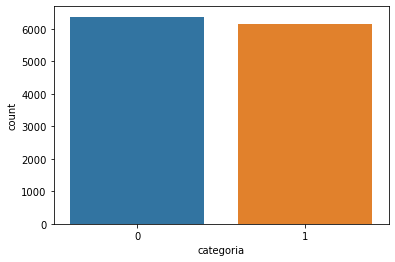

In [33]:
sns.countplot(test['categoria'])

Uma pequena amostra dos resultados.

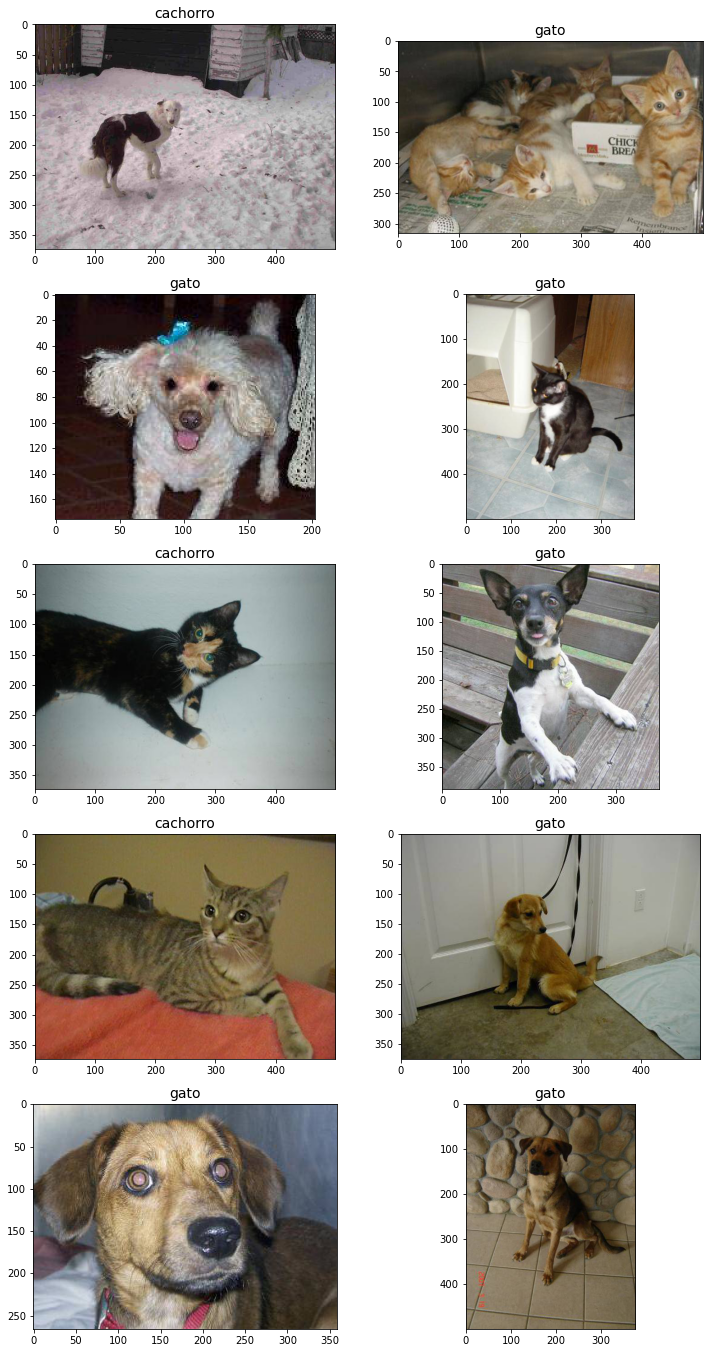

In [35]:
amostra = test.sample(n=10)
amostra['categoria'] = ['gato' if x==0 else 'cachorro' for x in amostra['categoria']]
plt.figure(figsize=(12, 24))
for i in range(10):
    img = load_img(amostra['arquivo'].iloc[i])
    plt.subplot(5, 2, i+1)
    plt.title(amostra['categoria'].iloc[i], fontsize=14)
    plt.imshow(img)